# Convolutional Neural  -- Lab 1

### Author: Chamberlain Mbah.



In this Notebook we will implement a **basic CNN in TensorFlow 2.0**. we will use the famous **Fashion MNIST** dataset, [published by Zalando](https://github.com/zalandoresearch/fashion-mnist) and made [available on Kaggle](https://www.kaggle.com/zalando-research/fashionmnist). Images come already preprocessed in 28 x 28 black and white format.

It is a multiclass classification task on the following labels:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot 

![](https://limetta.se/globalassets/nyhetbloggpress-bilder/fashion-mnist.jpg)

Summary:

0. Import data and do Data prep
0. CNN architecture
0. Training with Mini Batch Gradient Descent
0. Test

In [1]:
# Import necessary modules

import numpy as np
import pandas as pd

import tensorflow as tf
print(tf.__version__)

from sklearn.utils import shuffle

from matplotlib import pyplot as plt
import seaborn

2.4.1


# 0. Import data + Dataprep

The dataset comes already divided in 60k and 10k Train and Test images. We will now import Training data, and leave Test for later. In order to dataprep image data, we need to reshape the pixel into `(, 28, 28, 1)` arrays; 

Question:
* What does the 1 in the turple above represent?
* How can we get the colour channels?

In [2]:
### Fill in the blanks
### download fashion-mnist_train file and load
fm = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fm.load_data()

X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0],28*28))
y_train_df = pd.DataFrame(y_train, columns = ['label'])
df = pd.concat([X_train_df, y_train_df], axis = 1)### read in the file and assign it to df

In [3]:
# extract labels, one-hot encode them
label = df.label
label = pd.get_dummies(label)
label = label.values
label = label.astype(np.float32)

df.drop('label', axis = 1, inplace = True)
df = df.values
df = df.astype(np.float32)

# reshape and scale data
df = df.reshape((len(df), 28, 28, 1))
df = df / 255.

# 1. CNN architecture

We will feed images into a set of **convolutional** and **max-pooling layers**:

- Conv layers are meant to extract relevant informations from pixel data. A number of *filters* scroll through the image, learning the most relevant informations to extract.
- Max-Pool layers instead are meant to drastically reduce the number of pixel data. For each (2, 2) window size, Max-Pool will save only the pixel with the highest activation value. Max-Pool is meant to make the model lighter by removing the least relevant observations, at the cost of course of loosing a lot of data!



Con and Max-Pool will extract and reduce the size of the input, so that the following feed-forward part could process it. The first convolutional layer requires a specification of the input shape, corresponding to the shape of each image.

Since it's a multiclass classification tasks, softmax activation must be placed at the output layer in order to transform the Network's output into a probability distribution over the ten target categories.

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.activations import relu, elu, softmax


CNN = Sequential([
    
    Conv2D(32, kernel_size = (3, 3), activation = elu, 
           kernel_initializer = 'he_normal', input_shape = (28, 28, 1)), 
    MaxPool2D((2, 2)), 
    
    Conv2D(64, kernel_size = (3, 3), kernel_initializer = 'he_normal', activation = elu), 
    BatchNormalization(), 
    
    Conv2D(128, kernel_size = (3, 3), kernel_initializer = 'he_normal', activation = elu), 
    BatchNormalization(), 
    Dropout(0.2), 
    
    
    Flatten(), 
    
    
    Dense(400, activation = elu), 
    BatchNormalization(), 
    Dropout(0.2), 
    
    Dense(400, activation = elu), 
    BatchNormalization(), 
    Dropout(0.2), 
    
    Dense(10, activation = softmax)
    
])

In [5]:
CNN.summary() ### do a summary of the network

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 128)         0

# 2. Training with Mini Batch Gradient Descent

The training part is no different from mini batch gradient descent training of feed-forward classifiers. 

Assuming you already know how it works, we will define a function to fetch mini batches into the Network and process with training in eager execution.

In [6]:
@tf.function
def fetch_batch(X, y, batch_size, epoch):
    start = epoch*batch_size
    
    X_batch = X[start:start+batch_size, :, :]
    y_batch = y[start:start+batch_size, :]
    
    return X_batch, y_batch

In [7]:
# To measure execution time
import time
start = time.time()

Since this Network has a high number of parameters (approx 4.4 million) it will require comparatively longer training times. For this reason, I will measure training not just in *epochs*, but also in *cycles*.

At each training cycle, we will shuffle the dataset and feed it into the Network in mini batches until it's completed. At the following cycle, we will reshuffle the data using a different random seed and repeat the process. (What weI called cycles are nothing but Keras' "epochs".)

Using 50 cycles and batches of size 120 on a 60.000 images dataset, we will be able to train the CNN for an overall number of 25.000 epochs.

In [8]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

loss = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy()

optimizer = tf.optimizers.Adam(learning_rate = 0.0001)


###  TRAINING

cycles = 10
batch_size = 120

loss_history = []
accuracy_history = []

for cycle in range(cycles):
    
    df, label = shuffle(df, label, random_state = cycle**2)
    
    for epoch in range(len(df) // batch_size):
        
        X_batch, y_batch = fetch_batch(df, label, batch_size, epoch)
        
        with tf.GradientTape() as tape:
            current_loss = loss(CNN(X_batch), y_batch)
        
        gradients = tape.gradient(current_loss, CNN.trainable_variables)
        optimizer.apply_gradients(zip(gradients, CNN.trainable_variables))
        
        loss_history.append(current_loss.numpy())
        
        current_accuracy = accuracy(CNN(X_batch), y_batch).numpy()
        accuracy_history.append(current_accuracy)
        accuracy.reset_states()
        
    print(str(cycle + 1) + '.\tTraining Loss: ' + str(current_loss.numpy()) 
                  + ',\tAccuracy: ' + str(current_accuracy))    
#
print('\nTraining complete.')
print('Final Loss: ' + str(current_loss.numpy()) + '. Final accuracy: ' + str(current_accuracy))

1.	Training Loss: 3.3078146,	Accuracy: 0.7916667
2.	Training Loss: 2.7619784,	Accuracy: 0.8333333
3.	Training Loss: 2.0910916,	Accuracy: 0.89166665
4.	Training Loss: 1.6611964,	Accuracy: 0.9
5.	Training Loss: 1.5163553,	Accuracy: 0.9166667
6.	Training Loss: 1.8109019,	Accuracy: 0.9
7.	Training Loss: 1.712959,	Accuracy: 0.9
8.	Training Loss: 1.2232434,	Accuracy: 0.94166666
9.	Training Loss: 1.5670031,	Accuracy: 0.9166667
10.	Training Loss: 2.054403,	Accuracy: 0.8833333

Training complete.
Final Loss: 2.054403. Final accuracy: 0.8833333


In [9]:
end = time.time()
print(end - start)  # around 3.5 hours :(

2122.5733087062836


ValueError: window_length must be odd.

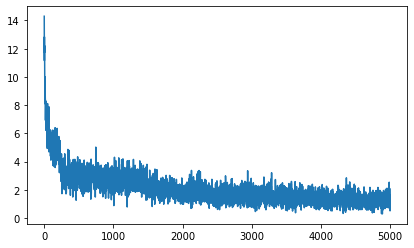

In [10]:
plt.figure(figsize = (15, 4))  # adjust figures size
plt.subplots_adjust(wspace=0.2)  # adjust distance

from scipy.signal import savgol_filter

# loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.plot(savgol_filter(loss_history, len(loss_history)//3, 3))
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Categorical Cross-Entropy')

# accuracy plot
plt.subplot(1, 2, 2)
plt.plot(accuracy_history)
plt.plot(savgol_filter(accuracy_history, len(loss_history)//3, 3))
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')

plt.show()

# 3. Test

Let's now test the model on the Test set. We will repeat the dataprep part on it:

In [ ]:
# Dataprep Test data

test = pd.read_csv('fashion-mnist_test.csv')

test_label = pd.get_dummies(test.label)
test_label = test_label.values
test_label = test_label.astype(np.float32)

test.drop('label', axis = 1, inplace = True)
test = test.values
test = test.astype(np.float32)

test = test / 255.

test = test.reshape((len(test), 28, 28, 1))

prediction = CNN.predict(test)

prediction = np.argmax(prediction, axis=1)
test_label = np.argmax(test_label, axis=1)  # reverse one-hot encoding

In [ ]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(prediction, test_label)
print(CM)
print('\nTest Accuracy: ' + str(np.sum(np.diag(CM)) / np.sum(CM)))

In [ ]:
seaborn.heatmap(CM, annot=True)
plt.show()

Our Convolutional Neural Network classified 91.7% of Test data correctly ... Can you check this?. The confusion matrix showed that category no. 6 (Shirt) has been misclassified the most. The next goal is to correct it; one possible solution would be to increase regularization, another to build an ensemble of models.